# Lab - Dogs vs Cats

Syftet med den här labben är att använda deep learning för computer vision för att lära sig att klassificera
olika objekt.

I den här labben kommer du få jobba med bildbehandling, filhantering, bygga upp egna tränings, validerings
och testdataset från en mängd av bilder. Vidare får du jobba med begränsade datamängder för att efterlikna
verkligheten när dataanskaffning är en oerhört dyr process. Efter databehandlingen och databearbetningen
kommer du få pröva olika slags convolutional neural networks tränade från scratch och slutligen använda
dig av transfer learning för att återanvända nätverk skapade av toppforskare inom computer vision.

## Uppgifter
Dokumentera i markdown i Jupyter notebook eller i separat markdownfil om du använder Pythonskript.

### 0. EDA och filhantering (*)

In [58]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import random
import os

#### c) Skapa folderstrukturen med Python

In [50]:
#for size in ["small", "tiny"]:
#    os.mkdir(f"experiment_{size}_data")
#    for dataset in ["test", "train", "val"]:
#        os.mkdir(f"experiment_{size}_data/{dataset}")

#os.rename("Pictures_of_dogs_and_cats", "original_data")

#### a) Börja med att ladda ned datasetet Dogs vs Cats från Kaggle. Extrahera den och lägg den i din labfolder, glöm inte att lägga till den till .gitignore.

#### b) Läs in 10 bilder slumpmässigt, plotta dem och extrahera deras labels och skriv ut i titeln.

In [62]:
def plot_random_sample(number_of_samples:int):
    
    # Initialise variables
    labels = [random.choice(["cat", "dog"]) for i in range(number_of_samples)]
    numbers = random.sample(range(12500), number_of_samples)
    images = []
    number_of_rows = None

    # Specifies number of rows to plot
    if number_of_samples % 5 == 0:
        number_of_rows = int(number_of_samples/5)
    else:
        number_of_rows = int((number_of_samples/5)+1)

    # Read the images and save the labels
    for label, number in zip(labels, numbers):
        if label == "cat":
            images.append(plt.imread(f"original_data/train/cat.{number}.jpg"))
        else:
            images.append(plt.imread(f"original_data/train/dog.{number}.jpg"))
    
    # Create plots
    fig, axes = plt.subplots(number_of_rows, 5, figsize=(20, 20))

    for i, ax, label in zip(range(number_of_samples), axes.flatten(), labels):
        ax.imshow(images[i]) 
        ax.axis("off")
        if label == "cat":
            ax.set(title="Cat: 0")
        else:
            ax.set(title="Dog: 1")

    fig.subplots_adjust(wspace=0.1, hspace=0.1, bottom=0.01, top=0.4)

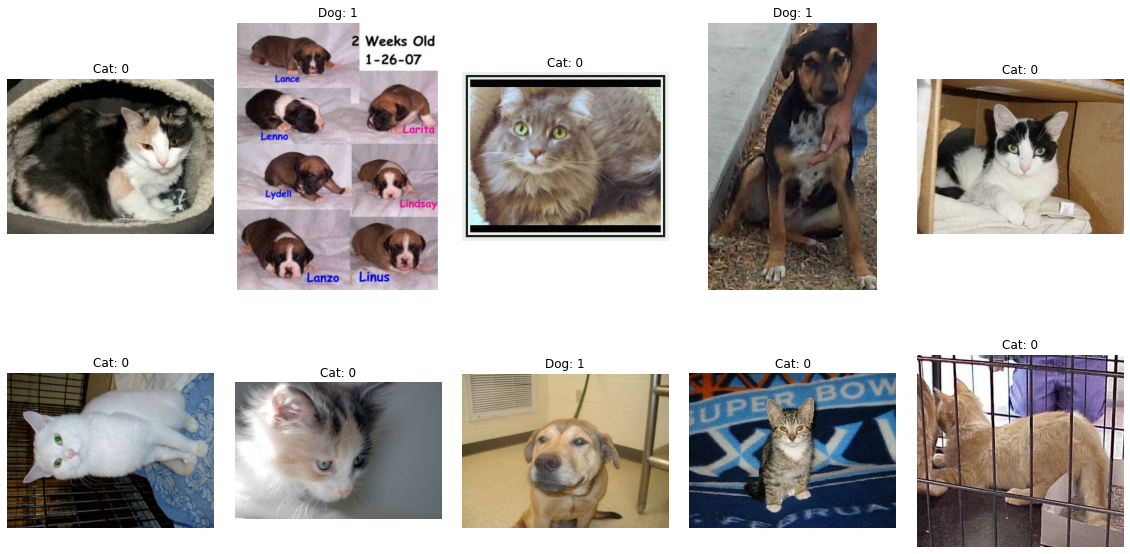

In [63]:
plot_random_sample(10)

#### d) Nu ska du göra train|val|test split med följande splits:

experiment_small
- train - 1600 (800 dogs, 800 cats)
- val - 400 (200 dogs, 200 cats)
- test - 500 (250 dogs, 250 cats)

experiment_tiny (BONUS)
- train - 160 (80 dogs, 80 cats)
- val - 40 (20 dogs, 20 cats)
- test - 50 (25 dogs, 25 cats)

In [69]:
img_names = pd.DataFrame({"name" : os.listdir("original_data/train")})
img_names["cat"] = img_names["name"].str.contains("cat") 

cats = img_names[img_names["cat"] == True]
dogs = img_names[img_names["cat"] == False]
len(cats), len(dogs)

(12500, 12500)

,name,cat
0,dog.8011.jpg,False
2,dog.7322.jpg,False
6,dog.1753.jpg,False
9,dog.5535.jpg,False
13,dog.3144.jpg,False
...,...,...
24992,dog.9316.jpg,False
24994,dog.6025.jpg,False
24995,dog.8008.jpg,False
24996,dog.1992.jpg,False
